In [111]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

In [112]:
# Base directory
BASE_DIR = Path("../../data")
RAW_DIR = BASE_DIR / "raw" / "widsdatathon2025"
PROCESSED_DIR = BASE_DIR / "preprocessed"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

In [113]:
# Load Training Data
train_cat = pd.read_excel(RAW_DIR / "TRAIN/TRAIN_CATEGORICAL_METADATA.xlsx")
train_fcm = pd.read_csv(RAW_DIR / "TRAIN/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.csv")
train_quant = pd.read_excel(RAW_DIR / "TRAIN/TRAIN_QUANTITATIVE_METADATA.xlsx")
train_solutions = pd.read_excel(RAW_DIR / "TRAIN/TRAINING_SOLUTIONS.xlsx")

In [114]:
# Load Test Data
test_cat = pd.read_excel(RAW_DIR / "TEST/TEST_CATEGORICAL.xlsx")
test_fcm = pd.read_csv(RAW_DIR / "TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv")
test_quant = pd.read_excel(RAW_DIR / "TEST/TEST_QUANTITATIVE_METADATA.xlsx")

In [115]:
# Subdirectories for different types of joins and transformations
JOIN_TYPES = ['outer', 'left', 'right']
SCALING_METHODS = ['standard', 'minmax']
TRANSFORMATIONS = ['original', 'log']

for join_type in JOIN_TYPES:
    for scaling_method in SCALING_METHODS:
        for transformation in TRANSFORMATIONS:
            dir_path = PROCESSED_DIR / join_type / scaling_method / transformation
            dir_path.mkdir(parents=True, exist_ok=True)

In [116]:
# print number of columns
print(f"Number of columns in train_cat {len(train_cat.columns)}")
print(f"Number of columns in test_cat {len(test_cat.columns)}")

print(f"Number of columns in train_fcm {len(train_fcm.columns)}")
print(f"Number of columns in test_fcm {len(test_fcm.columns)}")

print(f"Number of columns in train_quant {len(train_quant.columns)}")
print(f"Number of columns in test_quant {len(test_quant.columns)}")

print(f"Number of columns in train_solutions {len(train_solutions.columns)}")

Number of columns in train_cat 10
Number of columns in test_cat 10
Number of columns in train_fcm 19901
Number of columns in test_fcm 19901
Number of columns in train_quant 19
Number of columns in test_quant 19
Number of columns in train_solutions 3


In [117]:
# See if any columns are different 
columns_train_cat = set(train_cat.columns)
columns_test_cat = set(test_cat.columns)
diff = list(columns_train_cat - columns_test_cat)
diff

[]

In [118]:
def one_hot_encode(df, reference_cols=None):
    """Convert integer categorical columns to category type, then one-hot encode."""
    for col in df.select_dtypes(include='int').columns:
        df[col] = df[col].astype('category')

    columns_to_encode = df.columns[1:].tolist()  # Remove participant_id
    encoded = pd.get_dummies(df[columns_to_encode], drop_first=True)

    encoded = encoded.applymap(lambda x: 1 if x is True else (0 if x is False else x)) # Copied from tutorial

    if reference_cols is not None:
        # Making sure that the test set has same number columns as train set after encoding
        missing_cols = set(reference_cols) - set(encoded.columns)
        for col in missing_cols:
            encoded[col] = 0  # Fill in missing columns with just zeros
        
        encoded = encoded[reference_cols]  # Reorder columns to match train set

    return pd.concat([df.drop(columns=columns_to_encode), encoded], axis=1)

# One-hot encode train set
train_cat_encoded = one_hot_encode(train_cat)

# Get reference columns after encoding
reference_columns = train_cat_encoded.columns[1:].tolist() 

# One-hot encode test set using train's columns
test_cat_encoded = one_hot_encode(test_cat, reference_cols=reference_columns)

/var/folders/qq/2xq_hbb10j75t18jqwpwnfzh0000gn/T/ipykernel_4524/2513724319.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  encoded = encoded.applymap(lambda x: 1 if x is True else (0 if x is False else x)) # Copied from tutorial
/var/folders/qq/2xq_hbb10j75t18jqwpwnfzh0000gn/T/ipykernel_4524/2513724319.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  encoded = encoded.applymap(lambda x: 1 if x is True else (0 if x is False else x)) # Copied from tutorial


In [119]:
# Number of columns after one hot encoding
print(f"number of columns in train_cat_encoded {len(train_cat_encoded.columns)}")
print(f"number of columns in test_cat_encoded {len(test_cat_encoded.columns)}")

number of columns in train_cat_encoded 55
number of columns in test_cat_encoded 55


In [120]:
# Merge DataFrames for Train & Test
def merge_dataframes(train_cat_encoded, train_fcm, train_quant, test_cat_encoded, test_fcm, test_quant, join_type):
    """Merge dataframes"""
    train_cat_fcm = pd.merge(train_cat_encoded, train_fcm, on='participant_id', how=join_type)
    train_df = pd.merge(train_cat_fcm, train_quant, on='participant_id', how=join_type)

    test_cat_fcm = pd.merge(test_cat_encoded, test_fcm, on='participant_id', how=join_type)
    test_df = pd.merge(test_cat_fcm, test_quant, on='participant_id', how=join_type)

    return train_df, test_df

train_df_outer, test_df_outer = merge_dataframes(train_cat_encoded, train_fcm, train_quant, test_cat_encoded, test_fcm, test_quant, 'outer')
train_df_left, test_df_left = merge_dataframes(train_cat_encoded, train_fcm, train_quant, test_cat_encoded, test_fcm, test_quant, 'left')
train_df_right, test_df_right = merge_dataframes(train_cat_encoded, train_fcm, train_quant, test_cat_encoded, test_fcm, test_quant, 'right')

In [121]:
# Get number of columns
print(f"Number of columns in train_df_outer: {len(train_df_outer.columns)}")
print(f"Number of columns in test_df_outer: {len(test_df_outer.columns)}")

print(f"Number of columns in train_df_left: {len(train_df_left.columns)}")
print(f"Number of columns in test_df_left: {len(test_df_left.columns)}")

print(f"Number of columns in train_df_right: {len(train_df_right.columns)}")
print(f"Number of columns in test_df_right: {len(test_df_right.columns)}")

Number of columns in train_df_outer: 19973
Number of columns in test_df_outer: 19973
Number of columns in train_df_left: 19973
Number of columns in test_df_left: 19973
Number of columns in train_df_right: 19973
Number of columns in test_df_right: 19973


In [122]:
# Handle Missing Values
def fill_missing_values(df):
    """Fill missing values with column means for numerical columns."""
    for col in df.columns:
        if df[col].isna().sum() > 0 and df[col].dtype in ['float64', 'int64']:
            df[col] = df[col].fillna(df[col].mean())
    return df

train_df_outer = fill_missing_values(train_df_outer)
test_df_outer = fill_missing_values(test_df_outer)

train_df_left = fill_missing_values(train_df_left)
test_df_left = fill_missing_values(test_df_left)

train_df_right = fill_missing_values(train_df_right)
test_df_right = fill_missing_values(test_df_right)

In [123]:
# Train and Test Split
def split_data(train_df, test_df, train_solutions):
    """Split data into features and target."""
    X_train = train_df.drop(columns=['participant_id'])
    y_train = train_solutions.drop(columns=['participant_id'])

    X_test = test_df.drop(columns=['participant_id'])
    return X_train, y_train, X_test

X_train_outer, y_train_outer, X_test_outer = split_data(train_df_outer, test_df_outer, train_solutions)
X_train_left, y_train_left, X_test_left = split_data(train_df_left, test_df_left, train_solutions)
X_train_right, y_train_right, X_test_right = split_data(train_df_right, test_df_right, train_solutions)

In [124]:
# Normalize Data using Standard Scaler
def normalize_data(X_train, X_test, scaling_method):
    """Normalize data using the specified scaling method."""
    if scaling_method == 'standard':
        scaler = StandardScaler()
    elif scaling_method == 'minmax':
        scaler = MinMaxScaler()
    else:
        raise ValueError("Invalid scaling method. Choose 'standard' or 'minmax'.")

    X_train_normalized = scaler.fit_transform(X_train)
    X_test_normalized = scaler.transform(X_test) 

    # Convert back to dataframe
    X_train_normalized = pd.DataFrame(X_train_normalized, columns=X_train.columns)
    X_test_normalized = pd.DataFrame(X_test_normalized, columns=X_test.columns)

    return X_train_normalized, X_test_normalized

# Normalize data for each join type and scaling method
X_train_outer_standard, X_test_outer_standard = normalize_data(X_train_outer, X_test_outer, 'standard')
X_train_outer_minmax, X_test_outer_minmax = normalize_data(X_train_outer, X_test_outer, 'minmax')

X_train_left_standard, X_test_left_standard = normalize_data(X_train_left, X_test_left, 'standard')
X_train_left_minmax, X_test_left_minmax = normalize_data(X_train_left, X_test_left, 'minmax')

X_train_right_standard, X_test_right_standard = normalize_data(X_train_right, X_test_right, 'standard')
X_train_right_minmax, X_test_right_minmax = normalize_data(X_train_right, X_test_right, 'minmax')

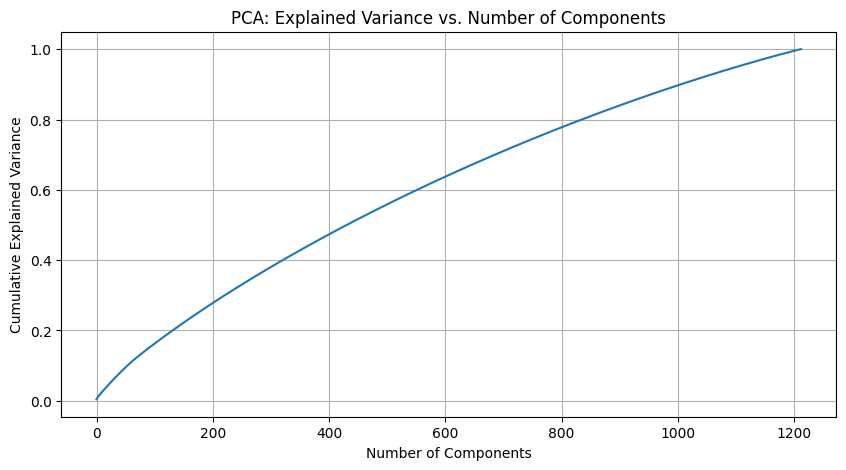

Number of components needed to explain 90% variance: 1007


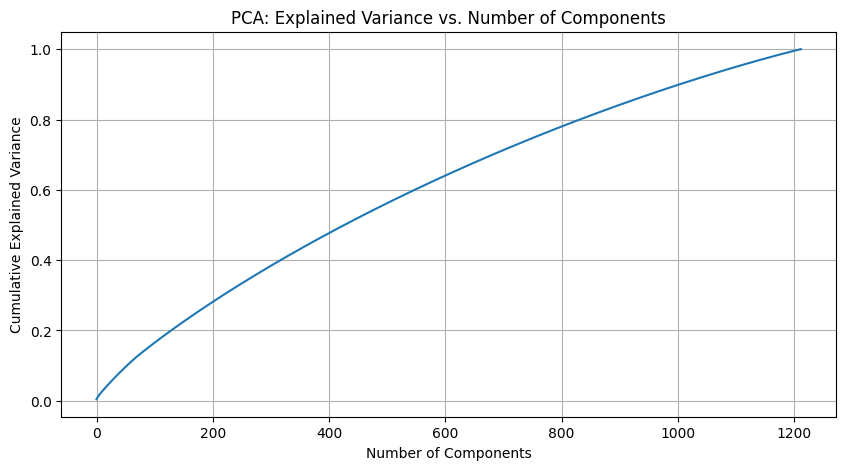

Number of components needed to explain 90% variance: 1004


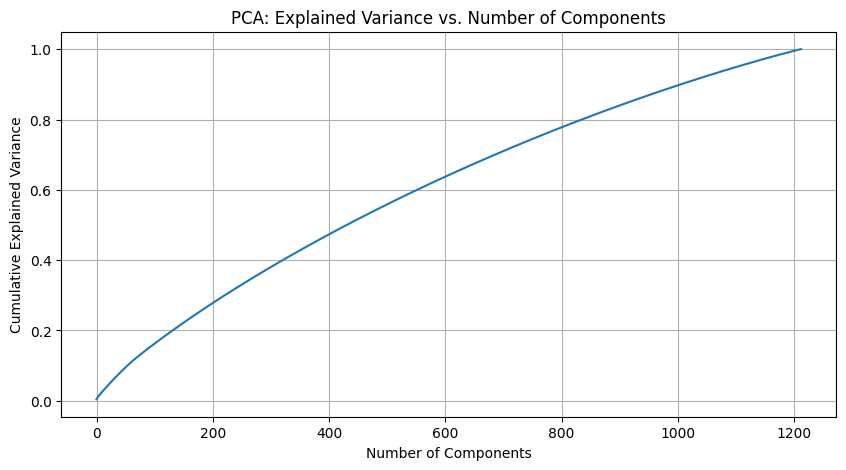

Number of components needed to explain 90% variance: 1007


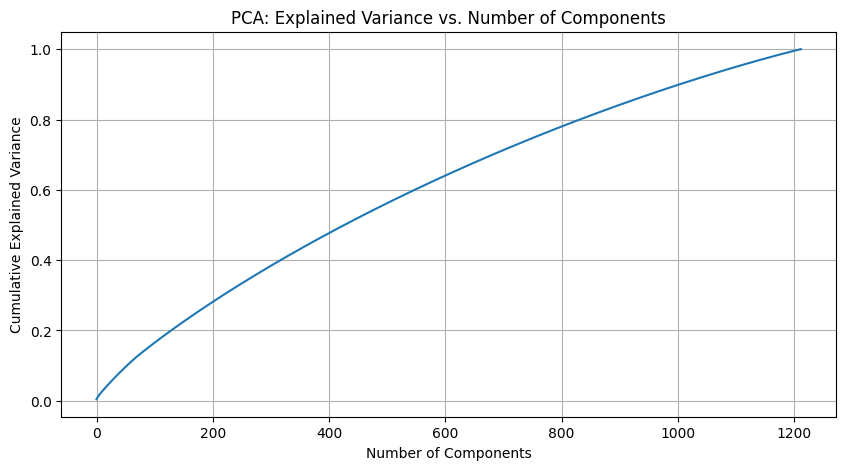

Number of components needed to explain 90% variance: 1004


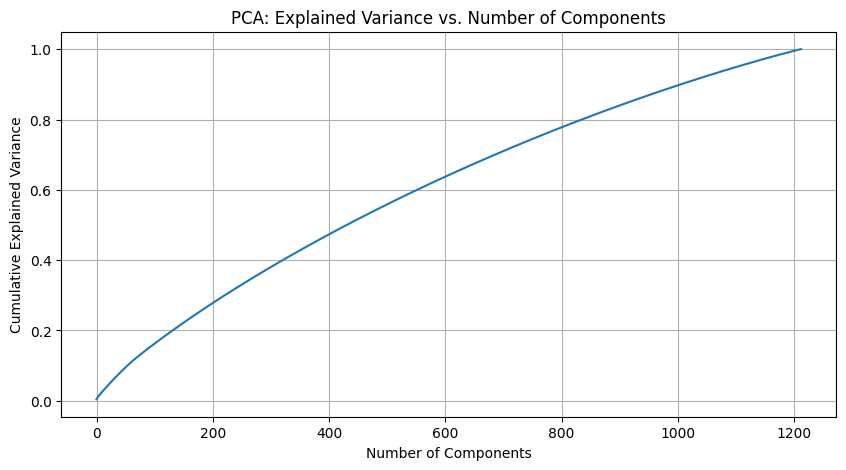

Number of components needed to explain 90% variance: 1007


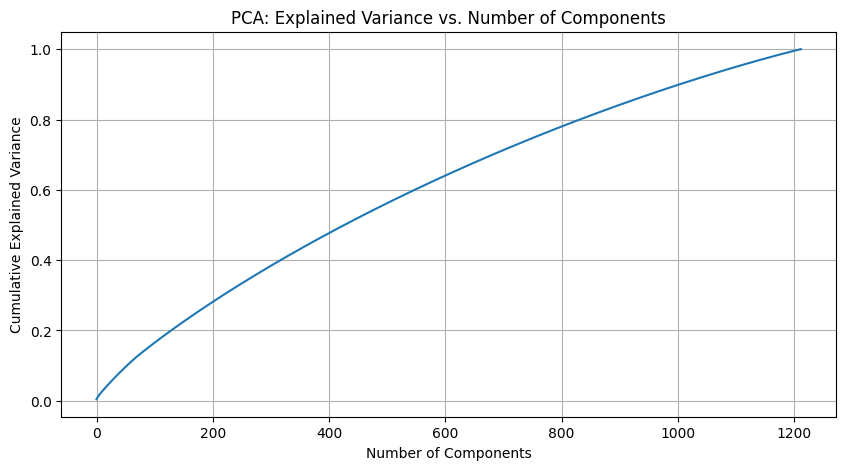

Number of components needed to explain 90% variance: 1004


In [125]:
# Get best number of Components for PCA
def determine_optimal_components(X_train_normalized):
    """Determine the optimal number of components to explain 90% variance."""
    pca_full = PCA().fit(X_train_normalized)
    cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
    n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1

    # Plot cumulative explained variance
    plt.figure(figsize=(10, 5))
    plt.plot(cumulative_variance)
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA: Explained Variance vs. Number of Components')
    plt.grid()
    plt.show()

    print(f"Number of components needed to explain 90% variance: {n_components_90}")
    return n_components_90

n_components_outer_standard = determine_optimal_components(X_train_outer_standard)
n_components_outer_minmax = determine_optimal_components(X_train_outer_minmax)

n_components_left_standard = determine_optimal_components(X_train_left_standard)
n_components_left_minmax = determine_optimal_components(X_train_left_minmax)

n_components_right_standard = determine_optimal_components(X_train_right_standard)
n_components_right_minmax = determine_optimal_components(X_train_right_minmax)

In [126]:
# PCA
def apply_pca(X_train_normalized, X_test_normalized, n_components):
    """Apply PCA to the normalized data."""
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_normalized)
    X_test_pca = pca.transform(X_test_normalized) 

    # Convert PCA results to DataFrame
    X_train_pca = pd.DataFrame(X_train_pca, columns=[f'PC{i+1}' for i in range(n_components)])
    X_test_pca = pd.DataFrame(X_test_pca, columns=[f'PC{i+1}' for i in range(n_components)])

    return X_train_pca, X_test_pca

# Apply PCA for each join type and scaling method
X_train_outer_standard_pca, X_test_outer_standard_pca = apply_pca(X_train_outer_standard, X_test_outer_standard, n_components_outer_standard)
X_train_outer_minmax_pca, X_test_outer_minmax_pca = apply_pca(X_train_outer_minmax, X_test_outer_minmax, n_components_outer_minmax)

X_train_left_standard_pca, X_test_left_standard_pca = apply_pca(X_train_left_standard, X_test_left_standard, n_components_left_standard)
X_train_left_minmax_pca, X_test_left_minmax_pca = apply_pca(X_train_left_minmax, X_test_left_minmax, n_components_left_minmax)

X_train_right_standard_pca, X_test_right_standard_pca = apply_pca(X_train_right_standard, X_test_right_standard, n_components_right_standard)
X_train_right_minmax_pca, X_test_right_minmax_pca = apply_pca(X_train_right_minmax, X_test_right_minmax, n_components_right_minmax)


In [127]:
# Add back participant_id
def add_participant_id(X_train, X_test, train_df, test_df):
    """Add participant_id back to the dataframes."""
    X_train.insert(0, 'participant_id', train_df['participant_id'].values)
    X_test.insert(0, 'participant_id', test_df['participant_id'].values)
    return X_train, X_test

# Add participant_id back to each dataframe
X_train_outer_standard, X_test_outer_standard = add_participant_id(X_train_outer_standard, X_test_outer_standard, train_df_outer, test_df_outer)
X_train_outer_minmax, X_test_outer_minmax = add_participant_id(X_train_outer_minmax, X_test_outer_minmax, train_df_outer, test_df_outer)

X_train_left_standard, X_test_left_standard = add_participant_id(X_train_left_standard, X_test_left_standard, train_df_left, test_df_left)
X_train_left_minmax, X_test_left_minmax = add_participant_id(X_train_left_minmax, X_test_left_minmax, train_df_left, test_df_left)

X_train_right_standard, X_test_right_standard = add_participant_id(X_train_right_standard, X_test_right_standard, train_df_right, test_df_right)
X_train_right_minmax, X_test_right_minmax = add_participant_id(X_train_right_minmax, X_test_right_minmax, train_df_right, test_df_right)

X_train_outer_standard_pca, X_test_outer_standard_pca = add_participant_id(X_train_outer_standard_pca, X_test_outer_standard_pca, train_df_outer, test_df_outer)
X_train_outer_minmax_pca, X_test_outer_minmax_pca = add_participant_id(X_train_outer_minmax_pca, X_test_outer_minmax_pca, train_df_outer, test_df_outer)

X_train_left_standard_pca, X_test_left_standard_pca = add_participant_id(X_train_left_standard_pca, X_test_left_standard_pca, train_df_left, test_df_left)
X_train_left_minmax_pca, X_test_left_minmax_pca = add_participant_id(X_train_left_minmax_pca, X_test_left_minmax_pca, train_df_left, test_df_left)

X_train_right_standard_pca, X_test_right_standard_pca = add_participant_id(X_train_right_standard_pca, X_test_right_standard_pca, train_df_right, test_df_right)
X_train_right_minmax_pca, X_test_right_minmax_pca = add_participant_id(X_train_right_minmax_pca, X_test_right_minmax_pca, train_df_right, test_df_right)

In [128]:
# Cell 17: Apply log transformation
def apply_log_transformation(df):
    """Apply log transformation to the numeric features."""
    # Select only numeric columns (excluding 'participant_id')
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].applymap(lambda x: np.log(x + 1) if x > 0 else x)
    return df

# Apply log transformation to each dataframe
X_train_outer_standard_log = apply_log_transformation(X_train_outer_standard)
X_test_outer_standard_log = apply_log_transformation(X_test_outer_standard)

X_train_outer_minmax_log = apply_log_transformation(X_train_outer_minmax)
X_test_outer_minmax_log = apply_log_transformation(X_test_outer_minmax)

X_train_left_standard_log = apply_log_transformation(X_train_left_standard)
X_test_left_standard_log = apply_log_transformation(X_test_left_standard)

X_train_left_minmax_log = apply_log_transformation(X_train_left_minmax)
X_test_left_minmax_log = apply_log_transformation(X_test_left_minmax)

X_train_right_standard_log = apply_log_transformation(X_train_right_standard)
X_test_right_standard_log = apply_log_transformation(X_test_right_standard)

X_train_right_minmax_log = apply_log_transformation(X_train_right_minmax)
X_test_right_minmax_log = apply_log_transformation(X_test_right_minmax)

/var/folders/qq/2xq_hbb10j75t18jqwpwnfzh0000gn/T/ipykernel_4524/3748689739.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[numeric_cols] = df[numeric_cols].applymap(lambda x: np.log(x + 1) if x > 0 else x)


In [129]:
def save_data(df, dir_path, file_name):
    """Save dataframe to the specified directory, creating the directory if it doesn't exist."""
    # Create the directory if it doesn't exist
    dir_path.mkdir(parents=True, exist_ok=True)
    
    # Save the dataframe to the specified file
    df.to_csv(dir_path / file_name, index=False)
    print(f"Data saved to {dir_path / file_name}")

In [130]:
# Define the data to save for each join type, scaling method, and transformation
data_to_save = {
    'outer': {
        'standard': {
            'original': (X_train_outer_standard, X_test_outer_standard),
            'log': (X_train_outer_standard_log, X_test_outer_standard_log),
            'pca': (X_train_outer_standard_pca, X_test_outer_standard_pca),
        },
        'minmax': {
            'original': (X_train_outer_minmax, X_test_outer_minmax),
            'log': (X_train_outer_minmax_log, X_test_outer_minmax_log),
            'pca': (X_train_outer_minmax_pca, X_test_outer_minmax_pca),
        },
    },
    'left': {
        'standard': {
            'original': (X_train_left_standard, X_test_left_standard),
            'log': (X_train_left_standard_log, X_test_left_standard_log),
            'pca': (X_train_left_standard_pca, X_test_left_standard_pca),
        },
        'minmax': {
            'original': (X_train_left_minmax, X_test_left_minmax),
            'log': (X_train_left_minmax_log, X_test_left_minmax_log),
            'pca': (X_train_left_minmax_pca, X_test_left_minmax_pca),
        },
    },
    'right': {
        'standard': {
            'original': (X_train_right_standard, X_test_right_standard),
            'log': (X_train_right_standard_log, X_test_right_standard_log),
            'pca': (X_train_right_standard_pca, X_test_right_standard_pca),
        },
        'minmax': {
            'original': (X_train_right_minmax, X_test_right_minmax),
            'log': (X_train_right_minmax_log, X_test_right_minmax_log),
            'pca': (X_train_right_minmax_pca, X_test_right_minmax_pca),
        },
    },
}

# Save all data using loops
for join_type in JOIN_TYPES:
    for scaling_method in SCALING_METHODS:
        for transformation in TRANSFORMATIONS:
            # Get the train and test data for the current combination
            train_data, test_data = data_to_save[join_type][scaling_method][transformation]
            
            # Define the directory path
            dir_path = PROCESSED_DIR / join_type / scaling_method / transformation
            
            # Save train and test data
            save_data(train_data, dir_path, 'train_data.csv')
            save_data(test_data, dir_path, 'test_data.csv')

Data saved to ../../data/preprocessed/outer/standard/original/train_data.csv
Data saved to ../../data/preprocessed/outer/standard/original/test_data.csv
Data saved to ../../data/preprocessed/outer/standard/log/train_data.csv
Data saved to ../../data/preprocessed/outer/standard/log/test_data.csv
Data saved to ../../data/preprocessed/outer/minmax/original/train_data.csv
Data saved to ../../data/preprocessed/outer/minmax/original/test_data.csv
Data saved to ../../data/preprocessed/outer/minmax/log/train_data.csv
Data saved to ../../data/preprocessed/outer/minmax/log/test_data.csv
Data saved to ../../data/preprocessed/left/standard/original/train_data.csv
Data saved to ../../data/preprocessed/left/standard/original/test_data.csv
Data saved to ../../data/preprocessed/left/standard/log/train_data.csv
Data saved to ../../data/preprocessed/left/standard/log/test_data.csv
Data saved to ../../data/preprocessed/left/minmax/original/train_data.csv
Data saved to ../../data/preprocessed/left/minmax/

In [133]:
# Define the PCA data to save for each join type and scaling method
pca_data_to_save = {
    'outer': {
        'standard': (X_train_outer_standard_pca, X_test_outer_standard_pca),
        'minmax': (X_train_outer_minmax_pca, X_test_outer_minmax_pca),
    },
    'left': {
        'standard': (X_train_left_standard_pca, X_test_left_standard_pca),
        'minmax': (X_train_left_minmax_pca, X_test_left_minmax_pca),
    },
    'right': {
        'standard': (X_train_right_standard_pca, X_test_right_standard_pca),
        'minmax': (X_train_right_minmax_pca, X_test_right_minmax_pca),
    },
}

# Save PCA data using loops
for join_type in JOIN_TYPES:
    for scaling_method in SCALING_METHODS:
        # Get the train and test PCA data for the current combination
        train_data_pca, test_data_pca = pca_data_to_save[join_type][scaling_method]
        
        # Define the directory path for PCA data
        dir_path = PROCESSED_DIR / join_type / scaling_method / 'pca'
        
        # Create the directory if it doesn't exist
        dir_path.mkdir(parents=True, exist_ok=True)
        
        # Save train and test PCA data
        train_data_pca.to_csv(dir_path / 'train_data_pca.csv', index=False)
        test_data_pca.to_csv(dir_path / 'test_data_pca.csv', index=False)
        
        print(f"PCA data saved to {dir_path}")

PCA data saved to ../../data/preprocessed/outer/standard/pca
PCA data saved to ../../data/preprocessed/outer/minmax/pca
PCA data saved to ../../data/preprocessed/left/standard/pca
PCA data saved to ../../data/preprocessed/left/minmax/pca
PCA data saved to ../../data/preprocessed/right/standard/pca
PCA data saved to ../../data/preprocessed/right/minmax/pca
